# Seq2Seq using Pytorch

This is taken from http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 


In [1]:
# imports 
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


## Preprocess
Just downloaded data to `data` dir  
1. Ran tokenizer on it.
2. Lowercased all the data


Note: Good idea to do pre processing using external tools

In [23]:
SOS_token = 0
EOS_token = 1

class Lang:

    SOS_token = 0
    EOS_token = 1

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def sentenceToIndices(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')]


    def sentenceToVariable(self, sentence):
        indexes = self.sentenceToIndices(sentence)
        indexes.append(Lang.EOS_token)
        result = Variable(torch.LongTensor(indexes).view(-1, 1))
        if use_cuda:
            result = result.cuda()
        return result


In [24]:
def prepareData(path, lang1, lang2, reverse=False):
    print("Reading from %s ..." % path)
    assert '%s-%s' % (lang1, lang2) in path

    # Read the file and split into lines
    lines = open('%s' % (path), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [l.split('\t') for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    #return input_lang, output_lang, pairs
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('../data/eng-fra.tok.lc.tsv', 'eng', 'fra', True)
print(random.choice(pairs))

Reading from ../data/eng-fra.tok.lc.tsv ...
Read 135842 sentence pairs
Trimmed to 135842 sentence pairs
Counting words...
Counted words:
fra 26109
eng 13572
['la gosse souffre de la chaleur .', 'the child is suffering from the heat .']


# Seq2Seq Model

In [49]:
class EncoderRNN(nn.Module):
    def __init__(self, lang, hidden_size):
        super(EncoderRNN, self).__init__()
        self.lang = lang
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(lang.n_words, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(input.size()[0], 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
class DecoderRNN(nn.Module):
    ## This decoder is dumb
    def __init__(self, hidden_size, lang):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lang = lang

        self.embedding = nn.Embedding(lang.n_words, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, lang.n_words)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        

In [21]:
def variablesFromPair(pair):
    input_variable = input_lang.variableFromSentence(pair[0])
    target_variable = output_lang.variableFromSentence(pair[1])
    return (input_variable, target_variable)

## Training

In [6]:
teacher_forcing_ratio = 0.5
MAX_LENGTH=100

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # store all outputs of encoder -- for attention 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        #print(ei, input_variable[ei])
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # For attention based decoder
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # For attention based decoder :
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [7]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    

0m 3s (- 0m 34s) (100 10%) 5.9293
0m 7s (- 0m 29s) (200 20%) 5.2699
0m 11s (- 0m 26s) (300 30%) 4.8584
0m 14s (- 0m 22s) (400 40%) 4.8306
0m 18s (- 0m 18s) (500 50%) 4.8380
0m 21s (- 0m 14s) (600 60%) 4.8896
0m 24s (- 0m 10s) (700 70%) 4.6523
0m 27s (- 0m 6s) (800 80%) 4.6427
0m 31s (- 0m 3s) (900 90%) 4.9035
0m 34s (- 0m 0s) (1000 100%) 4.5650


<Figure size 432x288 with 0 Axes>

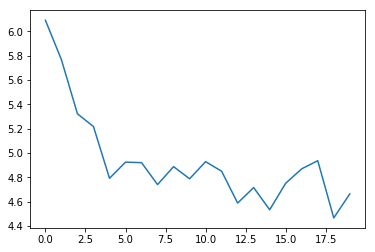

In [8]:
# Run the trainer

hidden_size = 256
enc = EncoderRNN(input_lang.n_words, hidden_size).cuda()
dec = DecoderRNN(hidden_size, output_lang.n_words).cuda()


trainIters(enc, dec, 1000, print_every=100, plot_every=50)

0m 3s (- 0m 35s) (100 10%) 4.5302
0m 7s (- 0m 30s) (200 20%) 4.6608
0m 10s (- 0m 24s) (300 30%) 4.6239
0m 13s (- 0m 20s) (400 40%) 4.5055
0m 16s (- 0m 16s) (500 50%) 4.6322
0m 19s (- 0m 13s) (600 60%) 4.6339
0m 23s (- 0m 9s) (700 70%) 4.5848
0m 26s (- 0m 6s) (800 80%) 4.4904
0m 30s (- 0m 3s) (900 90%) 4.6844
0m 33s (- 0m 0s) (1000 100%) 4.6031


<Figure size 432x288 with 0 Axes>

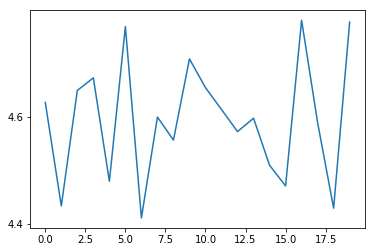

In [9]:
trainIters(enc, dec, 1000, print_every=100, plot_every=50)

## Evaluate

In [10]:
# Evaluate 

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        #decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        

In [11]:
evaluateRandomly(enc, dec)

> il ne prend pas de congés .
= he doesn 't take vacations .
< i 're 't know . <EOS>

> sais-tu ce que tom portait ?
= do you know what tom was wearing ?
< how do you ? ? <EOS>

> les oiseaux construisent des nids .
= birds build nests .
< i 're 't know . <EOS>

> j 'ai eu le sentiment que tu allais me le demander .
= i had the feeling you were going to ask me that .
< i 're 't know . <EOS>

> vous ne pouvez pas me sauver .
= you can 't save me .
< i 're 't know . <EOS>

> je ne dirais pas non à une bière , là .
= i wouldn 't mind a beer right now .
< i 're 't know . <EOS>

> ses yeux trahissaient sa peur .
= his eyes betrayed his fear .
< i 're 't know . <EOS>

> il n 'arriva pas à l 'heure .
= he didn 't come on time .
< i 're 't know . <EOS>

> tourne à droite au prochain carrefour .
= turn right at the next intersection .
< i 're 't know . <EOS>

> es-tu en train de te moquer de moi ?
= are you making fun of me ?
< how do you ? ? <EOS>



# Buffer

In [9]:
i, o = variablesFromPair(pairs[1000])

In [31]:
# Run the trainer

hidden_size = 256
enc = EncoderRNN(input_lang, hidden_size)
dec = DecoderRNN(hidden_size, output_lang)


if use_cuda:
    enc = enc.cuda()
    dec = dec.cuda()

In [30]:

class Trainer(object):
    
    def __init__(self, encr, decr, learning_rate=0.001):
        self.enc = encr
        self.dec = decr
        self.enc_optr = optim.SGD(encr.parameters(), lr=learning_rate)
        self.dec_optr = optim.SGD(decr.parameters(), lr=learning_rate)
        self.criterion = nn.NLLLoss()

    def _train_(self, seq_in, seq_out):

        self.enc_optr.zero_grad()
        self.dec_optr.zero_grad()
        in_len, out_len = seq_in.size()[0], seq_out.size()[0]
        loss = 0
        # Encoder
        enc_hidden = self.enc.initHidden()
        enc_outs, enc_hidden = self.enc(seq_in, enc_hidden)

        # Decoder
        dec_hidden = enc_hidden
        dec_input = Variable(torch.LongTensor([[SOS_token]])).cuda()
        for di in range(out_len):
            dec_out, dec_hidden = self.dec(dec_input, dec_hidden)
            topv, topi = dec_out.data.topk(1)
            ni = topi[0][0]
            dec_input = Variable(torch.LongTensor([[ni]])).cuda()
            loss += self.criterion(dec_out, seq_out[di])
            if ni == EOS_token:
                break

        loss.backward()

        self.enc_optr.step()
        self.dec_optr.step()

        return loss.data[0] / out_len
    
    def train(self, n_iters, pairs, print_every=1000, plot_every=100):
        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        
        train_pairs = [random.choice(pairs) for i in range(n_iters)]
        train_pairs = [(self.enc.lang.sentenceToVariable(src), 
                        self.dec.lang.sentenceToVariable(tgt)) for src, tgt in train_pairs]

        for iter in range(1, n_iters + 1):
            seq_in, seq_out = train_pairs[iter - 1]

            loss = self._train_(seq_in, seq_out)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
        showPlot(plot_losses)


0m 16s (- 0m 0s) (1000 100%) 5.6237


<Figure size 432x288 with 0 Axes>

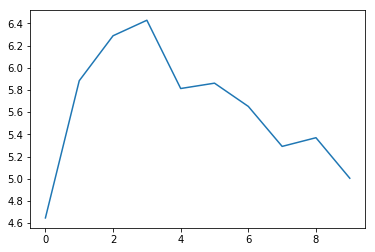

In [32]:
trainer = Trainer(enc, dec)
trainer.train(1000, pairs)

0m 19s (- 2m 55s) (1000 10%) 9.5444
0m 37s (- 2m 30s) (2000 20%) 9.5415
0m 55s (- 2m 9s) (3000 30%) 9.5414
1m 13s (- 1m 50s) (4000 40%) 9.5435
1m 31s (- 1m 31s) (5000 50%) 9.5392
1m 49s (- 1m 12s) (6000 60%) 9.5416
2m 7s (- 0m 54s) (7000 70%) 9.5411
2m 24s (- 0m 36s) (8000 80%) 9.5437
2m 43s (- 0m 18s) (9000 90%) 9.5443
3m 3s (- 0m 0s) (10000 100%) 9.5410


<Figure size 432x288 with 0 Axes>

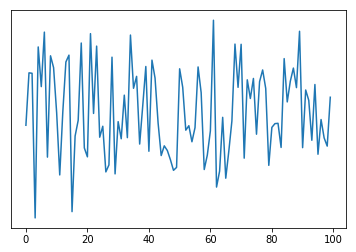

In [62]:
trainer.train(10000, pairs)

In [37]:
evaluateRandomly(enc, dec, 11)

> j 'ai été largué .
= i got dumped .
< i you you . <EOS>

> vous m 'importunez vraiment .
= you really annoy me .
< i you you . <EOS>

> qui se soucie des faits ?
= who cares about facts ?
< i you you . <EOS>

> il n 'a pas d 'ami avec qui jouer .
= he doesn 't have any friends to play with .
< i you you . <EOS>

> il ira aussi .
= he will also go .
< i you you . <EOS>

> combien de temps es-tu partie ?
= how long were you gone ?
< i you you . <EOS>

> tu devrais vraiment laisser tomber ça . ça va ruiner ta santé .
= you should really lay off that . it 'll ruin your health .
< i you you . <EOS>

> je vais devoir travailler dur .
= i 'll have to work hard .
< i you you . <EOS>

> plus grand ne veut pas toujours dire meilleur .
= bigger doesn 't always mean better .
< i you you . <EOS>

> il ressentit une douleur soudaine .
= he felt a sudden pain .
< i you you . <EOS>

> il lui fait du chantage .
= she is being blackmailed by him .
< i you you . <EOS>



In [47]:
class Translator(object):
    
    def __init__(self, enc, dec):
        self.enc = enc
        self.dec = dec

    def translate(self, sentence, max_length=MAX_LENGTH):
        enc_in = self.enc.lang.sentenceToVariable(sentence)
        enc_hidden = self.enc.initHidden()

        enc_outs, enc_hidden = self.enc(enc_in, enc_hidden)
        dec_in = Variable(torch.LongTensor([[SOS_token]]))  # SOS
        dec_in = dec_in.cuda() if use_cuda else dec_in

        dec_hidden = enc_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            dec_out, dec_hidden = self.dec(dec_in, dec_hidden)
            #dec_out, deco_hidden, decoder_attention = self.dec(dec_in, dec_hidden, enc_outs)
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = dec_out.data.topk(1)
            ni = topi[0][0]
            if ni == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.dec.lang.index2word[ni])

            dec_in = Variable(torch.LongTensor([[ni]]))
            dec_in = dec_in.cuda() if use_cuda else dec_in
        return decoded_words, decoder_attentions[:di + 1]

    def evaluateRandomly(self, pairs, n=10):
        for i in range(n):
            pair = random.choice(pairs)
            print('>', pair[0])
            print('=', pair[1])
            output_words, attentions = self.translate(pair[0])
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
            print()

    

In [48]:
trans = Translator(enc, dec)
trans.evaluateRandomly(pairs)

> je ne peux pas vous autoriser à entrer là .
= i can 't let you in there .
< i you you . <EOS>

> tu es maigrichon .
= you 're skinny .
< i you you . <EOS>

> où que l 'on regarde , on peut voir de jeunes couples en train de s 'embrasser .
= everywhere you look you can see young couples kissing .
< i you you . <EOS>

> l 'argent n 'est pas tout , mais si vous n 'avez pas d 'argent , vous ne pouvez rien faire .
= money isn 't everything , but if you have no money , you can 't do anything .
< i you you . <EOS>

> je suis impatient de te voir en robe de mariée .
= i 'm looking forward to seeing you in a wedding dress .
< i you you . <EOS>

> je vous ai fait attendre longtemps , je vous prie de m 'excuser .
= i 'm sorry i 've kept you waiting so long .
< i you you . <EOS>

> laisse-le s 'en aller !
= let him go !
< i you you . <EOS>

> je sais qu 'ils voudront tous vous aider .
= i know they 'll all want to help you .
< i you you . <EOS>

> nous devons faire ceci maintenant .
= we must do

# Attention Decoder
![](http://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [ ]:
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, lang, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(lang.n_words, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        self.attn = nn.Linear(2 * hidden_size, max_length)


    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(prev_word)
        emb_cat_hid = torch.cat((embedded[0], hidden[0]), 1)
        attn_weights = F.softmax(self.attn(emb_cat_hid), dim=1))
        
        

In [68]:
x = Variable(torch.rand((1, 4)))
print(x)
print(F.softmax(x, dim=1))

Variable containing:
 0.7493  0.8484  0.1063  0.1753
[torch.FloatTensor of size 1x4]

Variable containing:
 0.3132  0.3458  0.1646  0.1764
[torch.FloatTensor of size 1x4]

